# Elective Module Advanced Topics of Data Mining.
---
<b>MADS-EMDM Portfolio-Exam Part 1<br>
Janosch Höfer, 938969</b>

## Table of contents

- [Imports](#intro) <br>
- [1. Exercise](#ex1) <br>
- [2. Exercise](#ex2) <br>
- [3. Exercise](#ex3) <br>
- [4. Exercise](#ex4) <br>
- [5. Exercise](#ex5)

## Imports

In [1]:
# Standard libraries
import functools
import itertools
import os
import timeit

# Installed libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from tqdm.notebook import tqdm

# Own classes and functions
from helper_scripts.data_display import display_side_by_side, show_largest
from helper_scripts.data_manipulation import setup_raw_data

---
<a id='ex1'></a>

## 1. Exercise

Consider the following set of items: a, b, c, d, e, g, m in some transaction database. Assume that
<b>APRIORI</b> is running and has already computed the set 𝐿4 using alphabetical order on the items. The
resulting set is:

$$
L_4 = \begin{equation}
\left\{
    \begin{aligned}
        \{a, b, c, d\}, \{a, b, c, e\}, \{a, b, c, m\}, \{a, b, d, e\}, \{a, b, e, m\} \\
        \{a, c, e, m\}, \{a, d, g, m\}, \{b, c, d, e\}, \{b, c, d, g\}, \{b, c, d, m\} \\
        \{b, c, e, g\}, \{b, c, e, m\}, \{b, d, e, g\}, \{c, d, e, g\}, \{c, d, g, m\} \\
    \end{aligned}
    \right\}
\end{equation}
$$

### 1.1. Use the APRIORI candidate generation (and alphabetical order on the items) to create the set $C_5$ of candidates for 5-element frequent itemsets. Explain your decisions to create or discard elements.

In order to create the superset $C_5$ efficiently, only items which last position is different are combined. Using the last position is not mandatory. Any position would be adequate as long as it is applied the same to all items. For example, $\{a,b,c,d\}$ and $\{a,b,c,e\}$ are only different in the last place, therefore the candidate $\{a,b,c,d,e\}$ is created. This results in:

$$
C_5 = \begin{equation}
\left\{
    \begin{aligned}
        \{a, b, c, d, e\}, \{a,b,c,d,m\}, \{a,b,c,e,m\}, \{b, c, d, e, g\}, \{b, c, d, e, m\}, \{b, c, d, g, m\}, \{b, c, e, g, m\}
    \end{aligned}
    \right\}
\end{equation}
$$

The candidates are then pruned. Because of the monotonicity of support, the superset's support can only be equal or less than the lowest support of its subsets. So, if any subset's support is below the threshold the superset can be discarded. For that all possible subsets that would create the potential $C_5$ candidates are created and checked whether they are in $L_4$. Doing this the following $C_5$ candidates can be removed:

$$
\begin{equation}
\begin{aligned}
\{a, b, c, d, e\} &\Rightarrow missing\,\{a,c,d,e\} \\
\{a, b, c, d, m\} &\Rightarrow missing\,\{a,c,d,m\} \\
\{b, c, d, e, m\} &\Rightarrow missing\,\{b,d,e,m\} \\
\{b, c, d, g, m\} &\Rightarrow missing\,\{b,d,g,m\} \\
\{b, c, e, g, m\} &\Rightarrow missing\,\{b,e,g,m\} \\
\end{aligned}
\end{equation}
$$

Resulting in:
$$
C_5 = \begin{equation}
\left\{
    \begin{aligned}
        \{a, b, c, e, m\}, \{b, c, d, e, g\}
    \end{aligned}
    \right\}
\end{equation}
$$

### 1.2. For how many itemsets does the database have to be scanned to yield $L_5$ from $C_5$?

Only for two, because all the other possible candidates could be pruned beforehand.

---
<a id='ex2'></a>

## 2. Exercise

### 2.1. Create the following grocery dataset:

In [2]:
dataset1 = [
    [
        "fish",
        "apples",
        "cider",
        "dragon fruit",
        "garlic",
        "ice cream",
        "mints",
        "prunes",
    ],
    ["apples", "bacon", "cider", "fish", "lemons", "mints", "oatmeal"],
    ["bacon", "fish", "ham", "jam", "oatmeal"],
    ["bacon", "cider", "kiwis", "spam", "prunes"],
    ["apples", "fish", "cider", "eggs", "lemons", "prunes", "mints", "nachos"],
]

### 2.2. Load the dataset T10I4D100K from the Frequent Itemset Mining Dataset Repository.

In [3]:
# Download data
filename_data = "T10I4D100K.dat"
data_url = "http://fimi.uantwerpen.be/data"
path_to_data = "data"
random_state = 1

setup_raw_data(f"{data_url}/{filename_data}", path_to_data, filename_data)

INFO:root:Found the correct data.


After downloading the data file, we must first bring it into the right format. First we split each row of text. Here it is important to remove the last entry in the list which is empty. This empty entry is the result of the method used, as can be seen in the example below:

In [4]:
"test\n".split("\n")

['test', '']

In [5]:
with open(os.path.join(path_to_data, filename_data), "r") as file:
    dataset2_raw = file.read().split("\n")[:-1]

Next we split each row into the items.

In [6]:
dataset2_raw[-2:]

['69 75 140 175 285 494 598 614 641 723 829 871',
 '32 239 372 419 448 510 540 581 674 752 802 844 887 922']

In [7]:
dataset2_long = [item.rstrip().split(" ") for item in dataset2_raw]
len(dataset2_long)

100000

Finally the dataset with 100.000 samples is reduced to 10.000.

In [8]:
dataset2 = dataset2_long[:10000]
len(dataset2)

10000

### 2.3. For each dataset compute the highest (relative) support that a non-empty itemset actually reaches.

Before we can calculate the support, we must first encode the transactions. For that we use the TransactionEncoder provided by the <i>mlxtend</i> library.

In [9]:
def encode_data(dataset: list[list], sparse: bool = False) -> pd:
    te = TransactionEncoder()
    te_ary = te.fit_transform(dataset, sparse=sparse)
    if sparse:
        return pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
    return pd.DataFrame(te_ary, columns=te.columns_)

In [10]:
data1 = encode_data(dataset1)
data2 = encode_data(dataset2)

With the encoded transactions, we are able to count the number of occurrences.

In [11]:
data1.head()

,apples,bacon,cider,dragon fruit,eggs,fish,garlic,ham,ice cream,jam,kiwis,lemons,mints,nachos,oatmeal,prunes,spam
0,True,False,True,True,False,True,True,False,True,False,False,False,True,False,False,True,False
1,True,True,True,False,False,True,False,False,False,False,False,True,True,False,True,False,False
2,False,True,False,False,False,True,False,True,False,True,False,False,False,False,True,False,False
3,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True,True
4,True,False,True,False,True,True,False,False,False,False,False,True,True,True,False,True,False


In [12]:
relsup_str = "relativ_support"

In [13]:
display_side_by_side(
    [show_largest(data1, relsup_str, 5), show_largest(data2, relsup_str, 5)],
    ["Grocery dataset", "T10I4D100K"],
)

,relativ_support
cider,0.800000
fish,0.800000
apples,0.600000
bacon,0.600000
mints,0.600000
,relativ_support
368,0.082300
529,0.070300
829,0.062900
354,0.061300


The highest relative support for the grocery dataset is 0.8 for the itemsets $\{cider\}$ and $\{fish\}$. The highest relative support for the T10I4D100k dataset is 0.0823 for the itemset $\{368\}$. Theoretically $\{cider, fish\}$ could have also a relative support of 0.8. But a higher relative support is impossible.

---
<a id='ex3'></a>

## 3. Exercise

### 3.1. Run and time APRIORI once on the grocery dataset using a support threshold of 0.4 and a fitting line magic command. How long did the run take? How many frequent itemsets were found?


Jupyter has two types of built-in magic commands: line magics and cell magics. Line magics use % are run the statement following them. Cell magics use %% and are applied to the complete cell. To measure time %time and %timeit are available. $time measures for how long a Python's statement or expression executed.<br>
Assigning variables inside of the magic commands might increase the runtime, but the difference it makes should be neglectable because we are comparing different datasets and not different functions. Were we interested in the performance of different functions, this difference could be important.

In [14]:
timeit_results_single = dict()

In [15]:
%time timeit_results_single["Grocery_Dataset"] = apriori(data1, min_support=0.4, use_colnames=True).shape[0]

CPU times: total: 0 ns
Wall time: 8.03 ms


In [16]:
print(f'The command found {timeit_results_single["Grocery_Dataset"]} frequent itemsets.')

The command found 54 frequent itemsets.


Apriori found 54 frequent itemsets for the grocery dataset. Its runtime is in the single- to lower double-digit millisecond range.

### 3.2. Run and time APRIORI once on the T10I4D100K dataset using a support threshold of 0.004 and a fitting line magic command. How long did the run take? How many frequent itemsets were found?

In [17]:
%time timeit_results_single["T10I4D100K"] = apriori(data2, min_support=0.004, use_colnames=True).shape[0]

CPU times: total: 32.6 s
Wall time: 32.7 s


In [18]:
print(f'The command found {timeit_results_single["T10I4D100K"]} frequent itemsets.')

The command found 2185 frequent itemsets.


Apriori found 2185 fequent itemsets for the T10I4D100K dataset. Its runtime is in the mid double-digit second range.

### 3.3. Time repeated runs of APRIORI on both datasets using the above respective support thresholds and a fitting line magic command where:

- on the grocery dataset, 10 measurements are taken, each relying on 10 executions
- on the T10I4D100K dataset, 10 measurements are taken, each relying on 1 execution.

Report average runtime together with standard deviation for both experiments.


%timeit can measure a statement repeatedly and returns the average runtime. %timeit can also return its measurements as variables.<br>

In [19]:
timeit_results = dict()

In [20]:
%timeit -o -n 10 -r 10 apriori(data1, min_support=0.4, use_colnames=True)

5.81 ms ± 464 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 5.81 ms ± 464 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)>

In [21]:
timeit_results["Grocery_Dataset"] = _

In [22]:
%timeit -o -n 1 -r 10 apriori(data2, min_support=0.004, use_colnames=True)

32 s ± 536 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 32 s ± 536 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [23]:
timeit_results["T10I4D100K"] = _

In [24]:
for key, timit_res in timeit_results.items():
    print(f"Results for '{key}':")
    print(
        f"The command ran on average for {timit_res.average:0.5f}"
        f" seconds and has a standard deviation of {timit_res.stdev:0.5f}"
    )

Results for 'Grocery_Dataset':
The command ran on average for 0.00581 seconds and has a standard deviation of 0.00046
Results for 'T10I4D100K':
The command ran on average for 31.99074 seconds and has a standard deviation of 0.53606


#### 3.4. Discuss limitations of the above approaches!

- Variables defined after the magic line commands or inside of cells started by a magic cell commands are not available outside of the magic commands. Therefore, timing functions with magic commands and using that functions results later on is not possible.
- It is terrible to use with a good linter. How the magic commands are used here they are accepted by the linter, but this results in strange reference of the results (use of _). Without a linter something like $result = \%timeit function()$ would have been possible and a maybe a cleaner solution. Further, the use of _ to reference the result of the previous cell is not guaranteed to work. If _ has been assigned a value, which is not uncommon in Python, it will no longer reference the result of the previous cell.
- Although it is very convenient to use magic commands for single commands or cells, referencing its results in other cells is rather laborious.
- Magic commands can not be used outside of the Jupyter notebook (e.g. Python scripts).
- The result of %time can only be used as an estimation of the runtime. The single measurement can be influenced by background processes and vary a lot. %timeit gives a much better approximation of the algorithms runtime, because it is repeated. But this is only true if the minimum runtime and not the average is compared.
- 10 measurements and 10 executions are not many. To get more precise results, more repeats are needed.
- All methods only measure the runtime on this machine. A different machine can have completely different results.

---
<a id='ex4'></a>

## 4. Exercise

### 4.1. Time and run APRIORI on both datasets, first on the regular (non-sparse) representation, then on a sparse representation.

- For the grocery dataset use 0.2, 0.4, 0.6, 0.8 as the support thresholds, run 10 measurements for each setting and use 10 executions for each measurement.
- For the T10I4D100K dataset use 0.002, 0.004, 0.008, 0.016, 0.032, 0.064 as the support thresholds, run 10 measurements for each setting and use 1 execution for each repetition.

Out of the 10 measurements, report only the minimum for each setting (column parameter and
support threshold).

The experiment setup consists of two custom function. One that times a given function and one that runs the time function for all parameter combinations and returns the results in a dataframe.

In [25]:
def run_and_time(func: callable, n_mes: int, n_exec: int, func_kwargs: dict) -> tuple[int, float]:
    part_func = functools.partial(func, **func_kwargs)  # Preload function
    results = timeit.repeat(part_func, repeat=n_mes, number=n_exec)
    min_time = min(results) * 1000  # convert to milliseconds
    _fun_results = part_func()  # runs the algorithm after timing for itemsets and memory
    memory = _fun_results.memory_usage().sum()
    itemsets = _fun_results.shape[0]
    return min_time, memory, itemsets


def experiment_maker(
    dataset: list[list], func: callable, parameters: dict[str:list]
) -> pd.DataFrame:
    # Loops through all parameter combinations
    results = list()
    max_len = np.prod([len(item) for item in parameters.values()])  # Iterables have no length
    for item in tqdm(itertools.product(*parameters.values()), total=max_len):
        data = encode_data(dataset, sparse=item[3])
        avg, memory, itemsets = run_and_time(
            func,
            item[1],
            item[2],
            {"df": data, "min_support": item[0], "use_colnames": item[4]},
        )
        results.append([*item, avg, data.memory_usage().sum(), memory, itemsets])
    run_resultnames = ["min_time [ms]", "memory_encoding", "memory_itemsets", "itemsets"]
    df_colnames = list(parameters.keys()) + run_resultnames
    df = pd.DataFrame(results, columns=df_colnames)
    df.columns = df.columns.str.capitalize()
    return df

The parameters are setup for the two datasets.

In [26]:
# Setup parameters
data1_params_sparse = {
    "min_supports": [0.2, 0.4, 0.6, 0.8],
    "measurements": [10],
    "executions": [10],
    "sparse": [False, True],
    "colnames": [False],
}
data2_params_sparse = {
    "min_supports": [0.002, 0.004, 0.008, 0.016, 0.032, 0.064],
    "measurements": [10],
    "executions": [1],
    "sparse": [False, True],
    "colnames": [False],
}

In [27]:
%%time
res_1_apri = experiment_maker(dataset1, apriori, data1_params_sparse)

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: total: 6.03 s
Wall time: 5.99 s


In [ ]:
%%time
res_2_apri = experiment_maker(dataset2, apriori, data2_params_sparse)

  0%|          | 0/12 [00:00<?, ?it/s]

After performing both experiments, the results are saved. This allows skipping the four hour long step once it has been run, because the data can just be loaded.

In [33]:
res_1_apri.to_parquet(os.path.join(path_to_data, "res_1.parquet"), engine="pyarrow")
res_2_apri.to_parquet(os.path.join(path_to_data, "res_2.parquet"), engine="pyarrow")

In [28]:
res_1_apri = pd.read_parquet(os.path.join(path_to_data, "res_1.parquet"), engine="pyarrow")
res_2_apri = pd.read_parquet(os.path.join(path_to_data, "res_2.parquet"), engine="pyarrow")

### 4.2. Display results on each dataset in a separate, suitable table (create useful columns), focussing on the comparison of runtime and memory consumption for executions on non-sparse and sparse data structures.

In [29]:
col_filter = [
    "Min_supports",
    "Sparse",
    "Min_time [ms]",
    "Memory_encoding",
    "Memory_itemsets",
    "Itemsets",
]

In [30]:
display_side_by_side(
    [res_1_apri[col_filter], res_2_apri[col_filter]],
    ["Grocery dataset", "T10I4D100K"],
)

,Min_supports,Sparse,Min_time [ms],Memory_encoding,Memory_itemsets,Itemsets
0,0.200000,False,121.907900,213,10128,625
1,0.200000,True,176.444800,293,10128,625
2,0.400000,False,50.732600,213,992,54
3,0.400000,True,86.699300,293,992,54
4,0.600000,False,40.083300,213,416,18
5,0.600000,True,61.096000,293,416,18
6,0.800000,False,17.246100,213,160,2
7,0.800000,True,26.462700,293,160,2
,Min_supports,Sparse,Min_time [ms],Memory_encoding,Memory_itemsets,Itemsets
0,0.002000,False,655947.090000,8660128,212224,13256


### 4.3. Interpret the results – state observations, limitations, advice regarding the use of sparse representations!


In [31]:
print(f"Grocery dataset unique items: {len(set([item for trans in dataset1 for item in trans]))}")
print(
    f"T10I4D100K dataset unique items: {len(set([item for trans in dataset2 for item in trans]))}"
)

Grocery dataset unique items: 17
T10I4D100K dataset unique items: 866


For both datasets the runtime rises with a lower minimum support. This is because with a lower minimum support more items are included in the search, making the itemset creation more expensive. The memory requirement of the itemsets also rises with a lower minimum support. This was foreseeable, because with a lower minimum support the number of itemsets that are above the threshold rises, too.

Comparing the runtime of sparse and non-sparse data, the grocery and T10I4D100K datasets have different results. While the grocery dataset's sparse data has longer runtimes, T10I4D100K dataset's sparse data is processed faster. The difference in runtime of sparse and non-sparse data between the two datasets is their size. The grocery dataset has only 5 transactions and 17 unique items, while the T10I4D100k dataset has 10.000 transactions with 866 unique items. This results in T10I4D100k not only having longer database scans. The database must also be scanned more often, because the number of potential itemsets is much larger. This difference between T10I4D100k and the grocey dataset increases exponentially. Using a sparse data representation on the much smaller dataset has therefore negative effects, because it adds an additional management layer on top which takes up more time than is saved by using the sparse representation. This can also be seen in the T10I4D100K dataset with a minimum support of 0.064. Here the non-sparse data is faster, because only two items $\{368\}$ and $\{529\}$ are considered. But with larger datasets and lower minimum supports sparse data not only decreases the runtime, it also decreases the memory consumption.<br>
The memory usage of the encodings does not change with a different minimum support, because the encodings are done for the full dataset and are created before the itemset creation or any supports are taken into account. However, it differs between sparse and non-sparse data representation. For the T10I4D100K dataset the sparse data requires less memory. For the grocery dataset the sparse data requires slightly more memory. This is again the consequence of the added management layer, outweighing the benefits for this small dataset.

Taking all this into account sparse data representation is useful when working with big datasets. Not only does it decrease the memory consumption it also speeds up the frequent itemsets generation. When using small datasets, sparse data is counterproductive and should not be used.

### 4.4. Explain, why only the minimum runtime is reported (in contrast to other options, like the average runtime).



Background processes. Comparing the minimum runtime is the closest to actually comparing the runtime of the algorithms without external influences. A random background process could increase the time for a single run and therefore increase the average runtime. Only comparing the fastest runtime minimizes this risk, because the probability that all runs were affected by some process is rather small.

---
<a id='ex5'></a>

## 5. Exercise

### 5.1. Time and run APRIORI and FP-Growth on both datasets.
 - For the grocery dataset use 0.2, 0.4, 0.6, 0.8 as the support thresholds, run 10 measurements for each setting and use 10 executions for each repetition, and
 - for the T10I4D100K dataset use 0.002, 0.004, 0.008, 0.016, 0.032, 0.064 as the support thresholds, run 10 measurements for each setting and use 1 execution for each repetition.

Out of the 10 measurements, report only the minimum for each setting (column parameter and
support threshold).

Similar parameter setup from before, but now without sparse data representations.

In [32]:
# Setup parameters
data1_params = {
    "min_supports": [0.2, 0.4, 0.6, 0.8],
    "measurements": [10],
    "executions": [10],
    "sparse": [False],
    "colnames": [False],
}
data2_params = {
    "min_supports": [0.002, 0.004, 0.008, 0.016, 0.032, 0.064],
    "measurements": [10],
    "executions": [1],
    "sparse": [False],
    "colnames": [False],
}

Because the parameters have not changed, instead of running the apriori algorithm again, the results of the non-sparse data from exercise 4 are reused and combined with the results for fpgrowth. This reduces the notebooks runtime by ~2 hours.<br>
DISCLAIMER: Should You require that the apriori is run again, You can set the run_again_apriori variable to True. Reusing the results from before could have the risk that during those measurements some background process was running, which could be now finished. But I would argue that this can be neglected for the following reasons:
 - The background processes should be reduced to a minimum before the notebook is started anyway.
 - Because the algorithms take so long, the chance that one run is uninterrupted is very low.
 - We are not comparing the exact measurements, but rather the scale of the measurements between apriori and fpgrowth.
 - If we wanted to compare exact measurements we must run more repeats.

In [33]:
run_again_apriori = False

In [34]:
%%time
res_1_fpg = experiment_maker(dataset1, fpgrowth, data1_params)
res_1_fpg["Algorithm"] = "fpgrowth"
if run_again_apriori:
    res_1_apri = experiment_maker(dataset1, apriori, data1_params)

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: total: 734 ms
Wall time: 720 ms


In [35]:
%%time
res_2_fpg = experiment_maker(dataset2, fpgrowth, data2_params)
res_2_fpg["Algorithm"] = "fpgrowth"
if run_again_apriori:
    res_2_apri = experiment_maker(dataset2, apriori, data2_params)

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: total: 30.1 s
Wall time: 30.2 s


### 5.2.Display results on each dataset in a separate, suitable table (create useful columns), focussing on the comparison of runtime for executions of the two algorithms.

In [36]:
res_1_apri["Algorithm"] = "apriori"
res_2_apri["Algorithm"] = "apriori"
if not run_again_apriori:
    res_1_apri = res_1_apri[res_1_apri["Sparse"] == False]
    res_2_apri = res_2_apri[res_2_apri["Sparse"] == False]

In [37]:
table_1 = pd.concat([res_1_apri, res_1_fpg]).sort_values(["Min_supports", "Algorithm"])
table_2 = pd.concat([res_2_apri, res_2_fpg]).sort_values(["Min_supports", "Algorithm"])

In [38]:
col_filter2 = [
    "Algorithm",
    "Min_supports",
    "Min_time [ms]",
    "Memory_encoding",
    "Memory_itemsets",
    "Itemsets",
]

In [39]:
display_side_by_side(
    [table_1[col_filter2], table_2[col_filter2]],
    ["Grocery dataset", "T10I4D100K"],
)

,Algorithm,Min_supports,Min_time [ms],Memory_encoding,Memory_itemsets,Itemsets
0,apriori,0.200000,121.907900,213,10128,625
0,fpgrowth,0.200000,28.537000,213,10128,625
2,apriori,0.400000,50.732600,213,992,54
1,fpgrowth,0.400000,12.850400,213,992,54
4,apriori,0.600000,40.083300,213,416,18
2,fpgrowth,0.600000,11.265800,213,416,18
6,apriori,0.800000,17.246100,213,160,2
3,fpgrowth,0.800000,9.764100,213,160,2
,Algorithm,Min_supports,Min_time [ms],Memory_encoding,Memory_itemsets,Itemsets
0,apriori,0.002000,655947.090000,8660128,212224,13256


### 5.3. Add a visual comparison by plotting the runtimes of both algorithms against the support thresholds into the same diagram (thus, one diagram per dataset). Use scaled axes where useful.

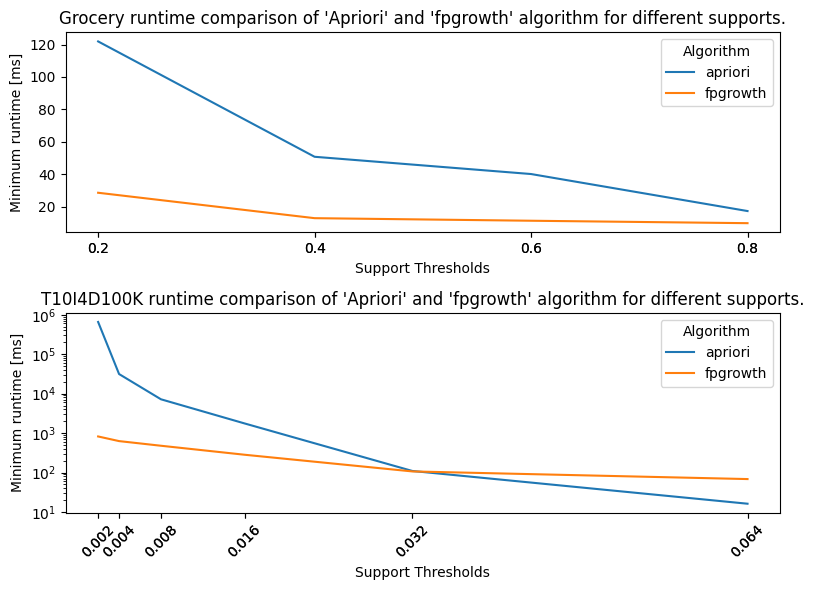

In [41]:
final_results = {"Grocery": table_1, "T10I4D100K": table_2}
fig, axes = plt.subplots(2, 1, figsize=(8, 6), dpi=100)
for idx, (key, _data) in enumerate(final_results.items()):
    sns.lineplot(data=_data, x="Min_supports", y="Min_time [ms]", hue="Algorithm", ax=axes[idx])
    axes[idx].set_xlabel("Support Thresholds")
    axes[idx].set_ylabel("Minimum runtime [ms]")
    axes[idx].set_title(
        f"{key} runtime comparison of 'Apriori' and 'fpgrowth' algorithm for different supports.",
    )
    axes[idx].set_xticks(_data["Min_supports"])
    if idx:
        for label in axes[idx].get_xticklabels():
            label.set_rotation(45)
        axes[idx].set_yscale("log")
plt.tight_layout()
plt.show()

### 5.4.  Interpret the results – state observations, limitations, advice regarding the use of the two algorithms!

As already observed in exercise 4, the runtime increases with a lower minimum support. The memory usage for each encoding/itemset per dataset stays the same for apriori and fpgrowth, because apriori and fpgrowth produce the same results.

Using the grocery dataset fpgrowth is always faster.
The time increase using apriori is almost parallel to the number of items exceeding a threshold. Going from a minimum support of 0.8 to 0.6, not only increases the number of items by 2x the runtime also increases by ~2x, Going from 0.6 to 0.4, the number of items increases by 0.5x and the runtime also increases by ~0.5x.

In [49]:
show_largest(data1, relsup_str, 10)

,relativ_support
cider,0.8
fish,0.8
apples,0.6
bacon,0.6
mints,0.6
prunes,0.6
lemons,0.4
oatmeal,0.4
dragon fruit,0.2
eggs,0.2


For T10I4D100K the results are not that distinct. When the minimum support is low, meaning a lot of items are considered, fpgrowth is vastly faster than apriori. While apriori scales almost exponentially, fpgrowth's runtime increases only linear. This stays true until the minimum support reaches 0.032. Here both algorithms have almost the same runtime. And with a minimum support of 0.064 apriori is faster than fpgrowth. The reason for this could be, that the tree- and header-table-generation of this fpgrowth implementation initially require more time. Both algorithms calculate the relative minimum support for all items. And both algorithms prune the items according to the minimum support threshold, leaving only two potential candidates. Although apriori requires more database scans than fpgrowth, those seem to be faster than the generation of the tree and header table. This benefit vanishes with more candidates.<br>
So why is this only true for the larger dataset? Looking at the items below shows, that both datasets only have two items with a relative support above the highest threshold. Why is only T10I4D100K the one with slower runtimes for fpgrowth?

In [40]:
display_side_by_side(
    [show_largest(data1, relsup_str, 5), show_largest(data2, relsup_str, 5)],
    ["Grocery dataset", "T10I4D100K"],
)

,relativ_support
cider,0.800000
fish,0.800000
apples,0.600000
bacon,0.600000
mints,0.600000
,relativ_support
368,0.082300
529,0.070300
829,0.062900
354,0.061300


The difference comes from the header table. The grocery dataset, with its few entries, only has a header table consisting of 5 transactions, while T10I4D100K's header table has 1.458 transactions. The header table is a result of Fpgrowth first dropping all items that are below the threshold from the transactions. It then loops through all remaining entries in the header table to create the tree. This takes longer for larger datasets. 

In [48]:
len([trans for trans in dataset2 if "368" in trans or "529" in trans])

1458

So, because of the initial creation of the header table and tree, fpgrowth can be slower than apriori. So when should which algorithm be used?
Fpgrowth is the better choice most of the time. Even on the much smaller dataset fpgrowth outperforms apriori by a factor of 4x for the biggest frequent itemsets. On the larger dataset the difference between the two is seconds vs multiple minutes. Its runtime does not increase exponentially. Apriori might be faster on very large datasets, if the minimum supports are chosen in a way, that yields only two or three frequent itemsets.

---
<a id='ref'></a>